In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_ = ".\\..\\data"
images_folder = os.path.join(data_, "images")
labels_folder = os.path.join(data_, "labels")


In [19]:
def plot_img(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

In [9]:
processed_data_path = os.path.join(data_, "processed_data")

if not os.path.exists(processed_data_path):
    os.makedirs(processed_data_path)

In [17]:
for image in os.listdir(images_folder):
    label_name = image[:-4] + ".txt"

    image = os.path.join(images_folder, image)
    label = os.path.join(labels_folder, label)

    img = cv2.imread(image)
    
    break

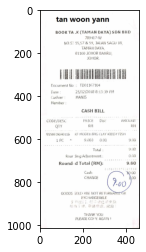

In [20]:
plot_img(img)

In [2]:
def get_all_coords(box):
    x = []
    y = []

    #coords are taken in clockwise direction
    x += [box[0], box[2], box[2], box[0]]
    y += [box[1], box[1], box[3], box[3]]

    return [x, y]

In [9]:
import os
import torch
import json
from PIL import Image
from torch.utils.data import Dataset


class RecieptDataset(Dataset):
    def __init__(self, root_dir, box_orientation = None, transform=None):
        super(RecieptDataset, self).__init__()

        self.root_dir = root_dir
        self.transform = transform
        self.box_orientation = box_orientation

        #find all image files
        self.image_names = [path for path in os.listdir(self.root_dir) if path.endswith(".jpg")]

    def __len__(self):
        return len(self.image_names)

    #TODO: Read docs and paper on image transform and normalization
    def __getitem__(self, idx):
        
        img_name = self.image_names[idx]
        label_name = img_name[:-4]+".json"

        img = Image.open(os.path.join(self.root_dir, img_name))
        label_name = json.load(open(os.path.join(self.root_dir, label_name)))

        bnd_boxes = []
        for label in label_name:
            if self.box_orientation is not None:
                #For AABB boxes
                bnd_boxes.append([min(label['x']), min(label['y']), max(label['x']), max(label['y']), self.box_orientation])
            else:
                #TODO: Add support of RBOX
                bnd_boxes.append([min(label['x']), min(label['y']), max(label['x']), max(label['y'])])

        if self.transform is not None:
            bnd_boxes = torch.Tensor(bnd_boxes)
            img, bnd_boxes = self.transform(img, bnd_boxes)

        return [img, bnd_boxes]


root_dir = "E:\\Projects\\2020\\OCR\\EAST\\data\\processed_data"

dataset = RecieptDataset(root_dir)
        

In [100]:
img, bnd_box = dataset.__getitem__(3)

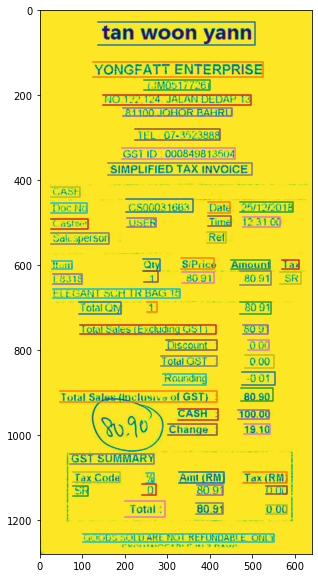

In [101]:
plt.figure(figsize=(10,10))
plt.imshow(img)

for box in bnd_box:
    box = get_all_coords(box)
    plt.plot(box[0], box[1])

In [12]:
a = np.array(box)

In [102]:
def scale_rectangle(box, scale):

    if type(box) == list:
        box = np.array(box)
    
    center = np.sum(box, axis=1)/4
    center = np.expand_dims(center, axis=1)
    cen_box = box - center
    cen_box = scale*cen_box

    box = cen_box + center

    return box.astype(int)


def map_score(score, box):
    h = box[1][3] - box[1][0]
    w = box[0][1] - box[0][0]

    score[box[1][0]:box[1][0]+h, box[0][0]:box[0][0]+w] = 1

    return score


def create_score_map(img, boxes):

    score = np.zeros_like(np.array(img))

    for box in bnd_box:
        box = get_all_coords(box)
        scaled_box = scale_rectangle(box, 0.7)
        score = map_score(score, scaled_box)

    return score


In [129]:
score = create_score_map(img, bnd_box)

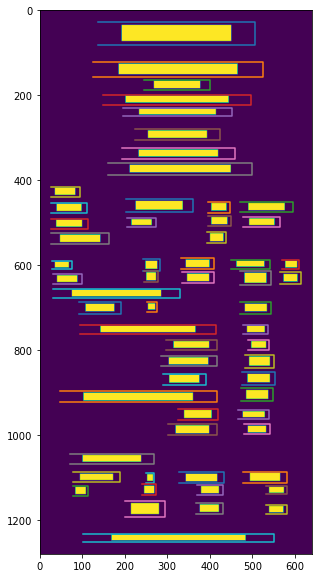

In [104]:
plt.figure(figsize=(10, 10))
plt.imshow(score)
for box in bnd_box:
    box = get_all_coords(box)
    plt.plot(box[0], box[1])

In [105]:
score.shape

(1280, 640)

In [106]:
def create_geometry_map(img, boxes):

    left = np.zeros_like(np.array(img))
    right = np.zeros_like(np.array(img))
    top = np.zeros_like(np.array(img))
    bottom = np.zeros_like(np.array(img))
    orientation = np.zeros_like(np.array(img))

    indices = np.indices(np.array(img).shape)

    for box in boxes:
        box = get_all_coords(box)
        #left box[0][0]
        left = calculate_geometry_score(box, indices, left, box[0][0], 1)
        #right box[0][1]
        right = calculate_geometry_score(box, indices, right, box[0][1], 1)
        #top box[1][0]
        top = calculate_geometry_score(box, indices, top, box[1][0], 0)
        #bittom box[1][2]
        bottom = calculate_geometry_score(box, indices, bottom, box[1][2], 0)
    
    geometry_map = np.stack([left, top, right, bottom, orientation])

    return geometry_map

In [107]:
def calculate_geometry_score(box, indices, map_, point, idx = 0):
    
    h = box[1][3] - box[1][0]
    w = box[0][1] - box[0][0]

    geo = indices[:, box[1][0]:box[1][0]+h, box[0][0]:box[0][0]+w]
    geo = np.sqrt(np.square(point - geo[idx]))

    map_[box[1][0]:box[1][0]+h, box[0][0]:box[0][0]+w] = geo

    return map_

In [108]:
m = create_geometry_map(img, bnd_box)

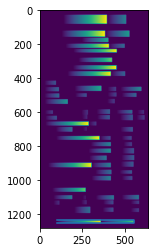

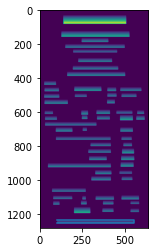

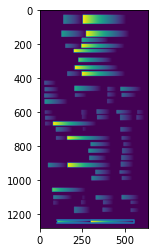

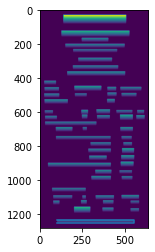

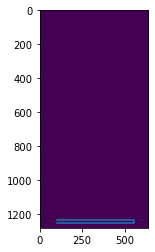

In [110]:
for i in range(len(m)):
    plt.imshow(m[i])
    plt.plot(box[0], box[1])
    plt.show()

In [134]:
score = np.expand_dims(score, axis=0)
a = np.concatenate([m, score], axis=0)

In [121]:
score.shape

(1, 1280, 640)

In [135]:
a.shape

(6, 1280, 640)